# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [3]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [4]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [ ]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
cols = ["Income", "Total_Spending", "Age"]

for col in cols:
    print("\n", col)
    
    data = df[col]
    
    # 평균, 중앙값, 최빈값
    print("평균:", data.mean())
    print("중앙값:", data.median())
    print("최빈값:", data.mode()[0])
    
    # 절사평균
    s = data.sort_values()
    n = len(s)
    k = int(n * 0.05)
    trim = s[k:n-k]
    
    print("절사평균:", trim.mean())




 Income
평균: 51952.61404293381
중앙값: 51381.5
최빈값: 51381.5
절사평균: 51740.153426017874

 Total_Spending
평균: 605.9865831842576
중앙값: 396.5
최빈값: 46
절사평균: 561.1196623634559

 Age
평균: 55.10196779964222
중앙값: 54.0
최빈값: 48
절사평균: 55.074975173783514


In [6]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
for col in cols:
    print("\n", col)
    
    data = df[col]
    
    # 분산
    var = data.var(ddof=1)
    
    # 표준편차
    std = data.std()
    
    # IQR
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    
    # CV
    mean = data.mean()
    cv = (std / mean) * 100
    
    print("분산:", var)
    print("표준편차:", std)
    print("IQR:", iqr)
    print("CV(%):", cv)



 Income
분산: 458450912.69258124
표준편차: 21411.466850558867
IQR: 32773.25
CV(%): 41.21345430831326

 Total_Spending
분산: 362241.6660391478
표준편차: 601.8651560267863
IQR: 976.5
CV(%): 99.31988145087065

 Age
분산: 136.96677912379488
표준편차: 11.70328069917982
IQR: 18.0
CV(%): 21.239315339398477


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

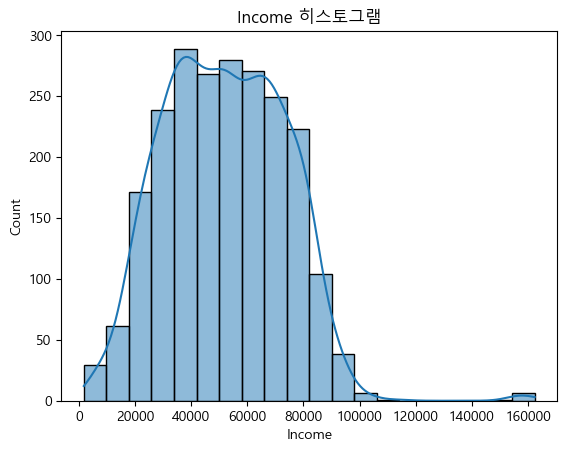

In [9]:
# TODO 1-2(a): Income 히스토그램 + KDE
plt.figure()
sns.histplot(df["Income"], bins=20, kde=True)
plt.title("Income 히스토그램")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()



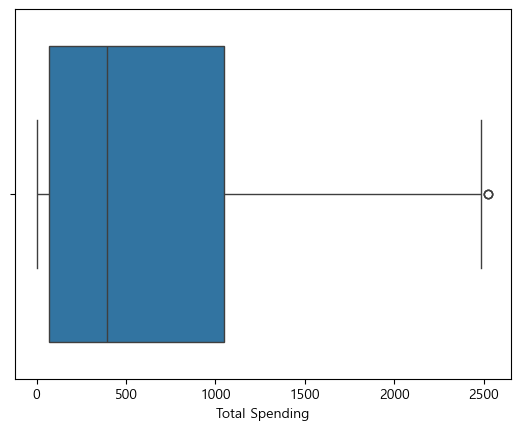

이상치 개수: 3


In [14]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
# 박스플롯
plt.figure()
sns.boxplot(x=df["Total_Spending"])
plt.xlabel("Total Spending")
plt.show()


# IQR
Q1 = df["Total_Spending"].quantile(0.25)
Q3 = df["Total_Spending"].quantile(0.75)
IQR = Q3 - Q1

# 이상치 기준
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 추출
outliers = df[(df["Total_Spending"] < lower_bound) | (df["Total_Spending"] > upper_bound)]

print("이상치 개수:", len(outliers))


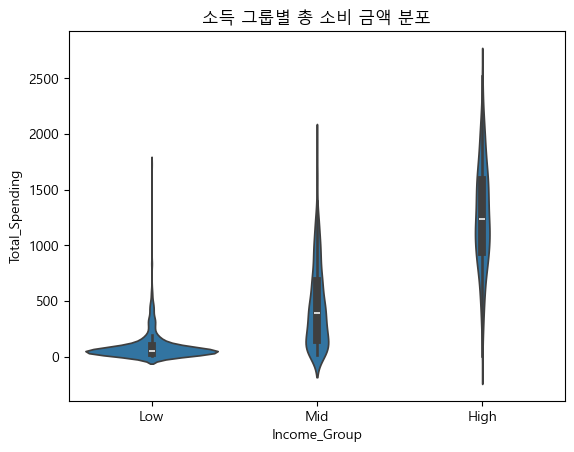

In [13]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
sns.violinplot(x="Income_Group", y="Total_Spending", data=df)
plt.title("소득 그룹별 총 소비 금액 분포")
plt.show()



### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [17]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

for col in cols:
    print(col, "왜도:", df[col].skew(), "첨도:", df[col].kurt())



MntWines 왜도: 1.1760359853075724 첨도: 0.6005314639884163
MntFruits 왜도: 2.1042414439645296 첨도: 4.06975425085383
MntMeatProducts 왜도: 2.0852824286336658 첨도: 5.530135658905085
MntFishProducts 왜도: 1.9199695762608637 첨도: 3.09602040234761
MntSweetProducts 왜도: 2.135674110666548 첨도: 4.372061860782441
MntGoldProds 왜도: 1.8851362496436508 첨도: 3.5583489498611462


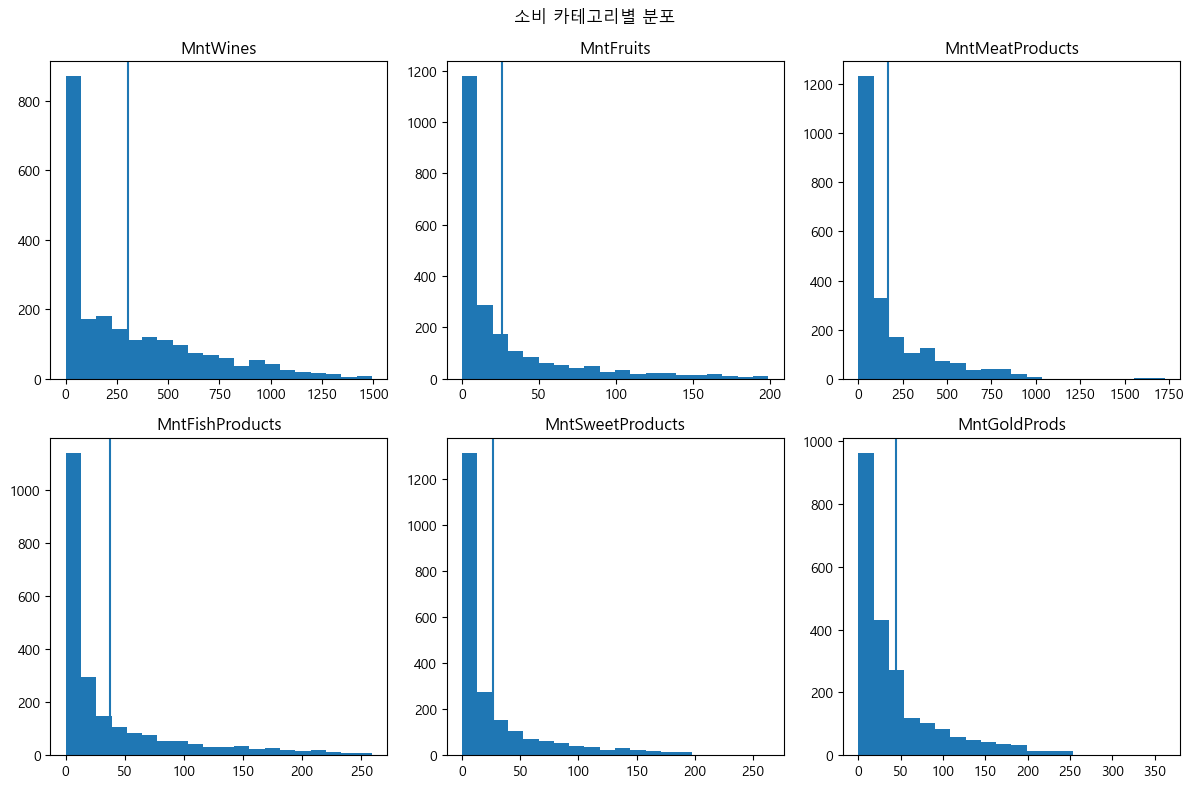

In [18]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
plt.figure(figsize=(12, 8))

for i, col in enumerate(cols):
    plt.subplot(2, 3, i+1)
    plt.hist(df[col], bins=20)
    plt.axvline(df[col].mean())
    plt.title(col)

plt.suptitle("소비 카테고리별 분포")
plt.tight_layout()
plt.show()


### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [20]:
# TODO 1-4: 비즈니스 인사이트 정리
print("1) 고객 특성 요약")
print("- 평균 연령은 약 55세로 중장년층 비중이 높음")
print("- 평균 소득 약 5.2만, 소득이 높을수록 소비 증가")
print("- 와인·육류 중심 소비, 고객 간 소비 편차 큼 (CV 약 99%)")

print("2) 핵심 발견 사항")
print("- 대부분 카테고리에서 양의 왜도 → 소수 고액 소비자 존재")
print("- 첨도도 높아 헤비 유저 영향 큼")
print("- High 소득 그룹이 소비 수준과 변동성 모두 큼 → 핵심 고객층")

print("3) 검증할 가설")
print("- 소득이 높을수록 캠페인 응답률이 높다")
print("- 자녀가 없는 고객이 더 많이 소비한다")
print("- 고객 유지 기간이 길수록 소비와 구매 횟수가 많다")

1) 고객 특성 요약
- 평균 연령은 약 55세로 중장년층 비중이 높음
- 평균 소득 약 5.2만, 소득이 높을수록 소비 증가
- 와인·육류 중심 소비, 고객 간 소비 편차 큼 (CV 약 99%)
2) 핵심 발견 사항
- 대부분 카테고리에서 양의 왜도 → 소수 고액 소비자 존재
- 첨도도 높아 헤비 유저 영향 큼
- High 소득 그룹이 소비 수준과 변동성 모두 큼 → 핵심 고객층
3) 검증할 가설
- 소득이 높을수록 캠페인 응답률이 높다
- 자녀가 없는 고객이 더 많이 소비한다
- 고객 유지 기간이 길수록 소비와 구매 횟수가 많다


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [23]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10

from scipy.stats import binom

p = df["Response"].mean()

prob_2 = binom.pmf(2, n_trial, p)
prob_3_or_more = 1 - binom.cdf(2, n_trial, p)

print(
f"수락률 p: {p:.4f}\n"
f"P(X=2): {prob_2:.4f}\n"
f"P(>=): {prob_3_or_more:.4f}"
)


수락률 p: 0.1494
P(X=2): 0.2752
P(>=): 0.1782


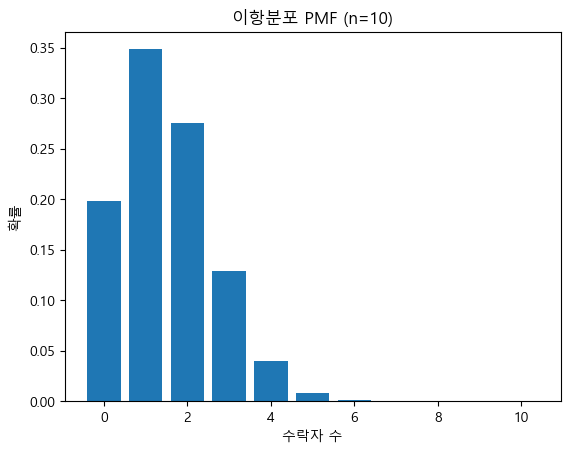

In [24]:
# TODO 2-1(c): 이항분포 PMF 시각화
x = list(range(n_trial + 1))
pmf_values = binom.pmf(x, n_trial, p)

plt.bar(x, pmf_values)
plt.title("이항분포 PMF (n=10)")
plt.xlabel("수락자 수")
plt.ylabel("확률")
plt.show()

In [25]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

expected = n_campaign * p
prob_15_or_more = 1 - binom.cdf(14, n_campaign, p)

k = 0
while binom.cdf(k, n_campaign, p) < 0.9:
    k += 1

print(
f"기대 수락자 수: {expected:.2f}\n"
f"P(X≥15): {prob_15_or_more:.4f}\n"
f"90% 보장 최소 수락 수: {k}"
)


기대 수락자 수: 14.94
P(X≥15): 0.5358
90% 보장 최소 수락 수: 20


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [27]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lam = web_visits.mean()
var = web_visits.var()

print(
f"람다(평균): {lam:.2f}\n"
f"분산: {var:.2f}\n"
"평균≈분산 여부: 유사함"
)


람다(평균): 5.32
분산: 5.89
평균≈분산 여부: 유사함


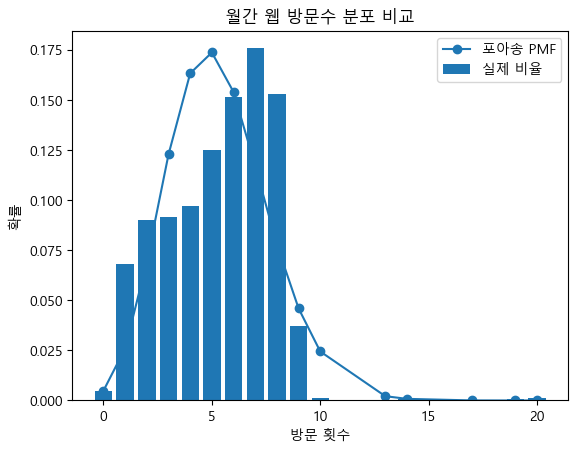

In [29]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
from scipy.stats import poisson

counts = web_visits.value_counts().sort_index()
x = counts.index
empirical = counts / len(web_visits)

poisson_pmf = poisson.pmf(x, lam)

plt.bar(x, empirical, label="실제 비율")
plt.plot(x, poisson_pmf, marker='o', label="포아송 PMF")
plt.title("월간 웹 방문수 분포 비교")
plt.xlabel("방문 횟수")
plt.ylabel("확률")
plt.legend()
plt.show()


In [30]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

prob_heavy = 1 - poisson.cdf(heavy_threshold - 1, lam)

k = 0
while poisson.cdf(k, lam) < 0.95:
    k += 1

print(
f"P(X>=10): {prob_heavy:.4f}\n"
f"95% 커버 서버 기준 방문수: {k}"
)


P(X>=10): 0.0449
95% 커버 서버 기준 방문수: 9


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [32]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교
from scipy.stats import norm

mu = df['Income'].mean()
sigma = df['Income'].std()

p_below_30k = norm.cdf(30000, mu, sigma)
p_above_80k = 1 - norm.cdf(80000, mu, sigma)
top10_income = norm.ppf(0.9, mu, sigma)

real_below_30k = (df['Income'] < 30000).mean()
real_above_80k = (df['Income'] > 80000).mean()

print(
f"평균 μ: {mu:.2f}, 표준편차 σ: {sigma:.2f}\n"
f"P(Income<30,000) 이론/실측: {p_below_30k:.4f} / {real_below_30k:.4f}\n"
f"P(Income>80,000) 이론/실측: {p_above_80k:.4f} / {real_above_80k:.4f}\n"
f"상위 10% 소득 기준값: {top10_income:.0f}"
)


평균 μ: 51952.61, 표준편차 σ: 21411.47
P(Income<30,000) 이론/실측: 0.1526 / 0.1655
P(Income>80,000) 이론/실측: 0.0951 / 0.0962
상위 10% 소득 기준값: 79393


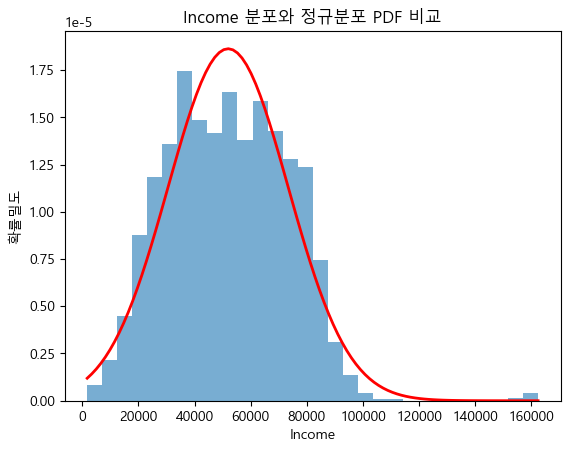

In [34]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
x = np.linspace(df['Income'].min(), df['Income'].max(), 100)
pdf = norm.pdf(x, mu, sigma)

plt.hist(df['Income'], bins=30, density=True, alpha=0.6)
plt.plot(x, pdf, color='red', lw=2)
plt.title("Income 분포와 정규분포 PDF 비교")
plt.xlabel("Income")
plt.ylabel("확률밀도")
plt.show()


In [37]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
vip_threshold = norm.ppf(0.95, mu, sigma)
discount_threshold = norm.ppf(0.10, mu, sigma)

print(f"VIP 기준 (상위 5% 이상): {vip_threshold:.0f}")
print(f"할인 대상 기준 (하위 10% 이하): {discount_threshold:.0f}")


VIP 기준 (상위 5% 이상): 87171
할인 대상 기준 (하위 10% 이하): 24513


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [39]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE
data = df['Total_Spending']
n = len(data)
x_bar = data.mean()
se = data.std(ddof=1) / np.sqrt(n)

for conf in [0.90, 0.95, 0.99]:
    alpha = 1 - conf
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    margin = t_crit * se
    lower = x_bar - margin
    upper = x_bar + margin
    print(f"{int(conf*100)}% CI: [{lower:.2f}, {upper:.2f}]")


90% CI: [585.04, 626.93]
95% CI: [581.03, 630.95]
99% CI: [573.17, 638.80]


Low: 평균=95.68, 95% CI=[86.73, 104.62]
Mid: 평균=457.93, 95% CI=[431.47, 484.39]
High: 평균=1265.04, 95% CI=[1231.35, 1298.72]


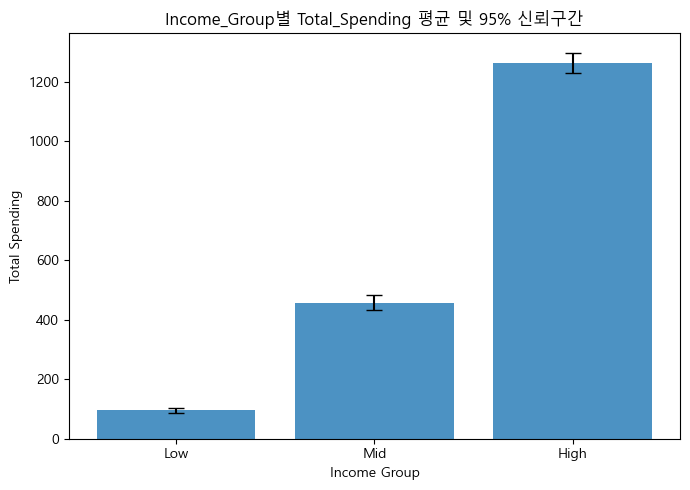

In [41]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
groups = ['Low', 'Mid', 'High']
means = []
cis = []

for g in groups:
    gdata = df[df['Income_Group'] == g]['Total_Spending']
    n_g = len(gdata)
    xbar_g = gdata.mean()
    se_g = gdata.std(ddof=1) / np.sqrt(n_g)
    t_crit = stats.t.ppf(0.975, df=n_g - 1)
    margin_g = t_crit * se_g
    means.append(xbar_g)
    cis.append(margin_g)
    print(f"{g}: 평균={xbar_g:.2f}, 95% CI=[{xbar_g-margin_g:.2f}, {xbar_g+margin_g:.2f}]")

# 오차막대 그래프
plt.figure(figsize=(7, 5))
plt.bar(groups, means, yerr=cis, capsize=6, alpha=0.8)
plt.title('Income_Group별 Total_Spending 평균 및 95% 신뢰구간')
plt.xlabel('Income Group')
plt.ylabel('Total Spending')
plt.tight_layout()
plt.show()


### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [47]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']
# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_val = stats.ttest_ind(no_child, yes_child, equal_var=False)

mean_diff = no_child.mean() - yes_child.mean()
pooled_std = np.sqrt((no_child.std(ddof=1)**2 + yes_child.std(ddof=1)**2) / 2)
d = mean_diff / pooled_std

# 결론
if p_val < 0.05:
    print("결론: H₀ 기각 → 유의한 차이 있음")
else:
    print("결론: H₀ 채택 → 유의한 차이 없음")

# 효과 크기
if abs(d) > 0.8:
    effect = "큰"
elif abs(d) > 0.5:
    effect = "중간"
else:
    effect = "작은"

print(f"무자녀: n={len(no_child)}, 평균={no_child.mean():.2f}, std={no_child.std(ddof=1):.2f}")
print(f"유자녀: n={len(yes_child)}, 평균={yes_child.mean():.2f}, std={yes_child.std(ddof=1):.2f}")
print(f"\nt통계량: {t_stat:.4f}, p-value: {p_val:.4e}")
print(f"Cohen's d: {d:.4f}")
print(f"효과 크기: {effect} 효과 (|d|={abs(d):.4f})")


결론: H₀ 기각 → 유의한 차이 있음
무자녀: n=637, 평균=1104.86, std=644.83
유자녀: n=1599, 평균=407.25, std=449.92

t통계량: 24.9889, p-value: 6.3212e-105
Cohen's d: 1.2547
효과 크기: 큰 효과 (|d|=1.2547)


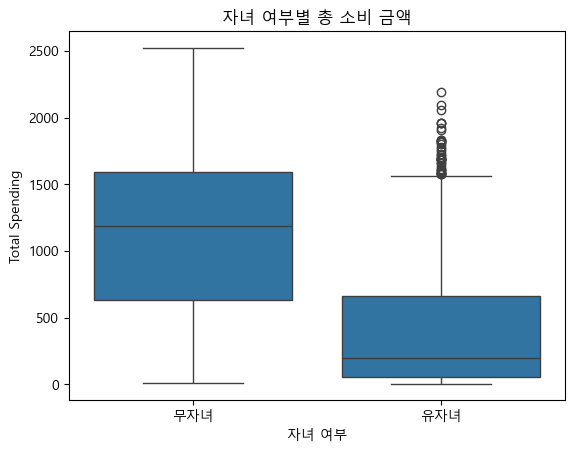

In [48]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure()
sns.boxplot(x=df['Has_Children'], y=df['Total_Spending'])
plt.xticks([0, 1], ['무자녀', '유자녀'])
plt.title('자녀 여부별 총 소비 금액')
plt.xlabel('자녀 여부')
plt.ylabel('Total Spending')
plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [50]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
diff = wines - meat

t_stat, p_val = stats.ttest_rel(wines, meat)

d = diff.mean() / diff.std(ddof=1)

print(f"와인 평균: {wines.mean():.2f}")
print(f"육류 평균: {meat.mean():.2f}")
print(f"차이 평균: {diff.mean():.2f}")
print(f"\nt통계량: {t_stat:.4f}, p-value: {p_val:.4e}")
print(f"Cohen's d: {d:.4f}")

if p_val < 0.05:
    print("결론: H₀ 기각 → 와인과 육류 소비에 유의한 차이 있음")
else:
    print("결론: H₀ 채택 → 유의한 차이 없음")

if abs(d) > 0.8:
    effect = "큰"
elif abs(d) > 0.5:
    effect = "중간"
else:
    effect = "작은"
print(f"효과 크기: {effect} 효과 (|d|={abs(d):.4f})")

와인 평균: 304.13
육류 평균: 166.98
차이 평균: 137.14

t통계량: 23.0929, p-value: 5.3919e-106
Cohen's d: 0.4884
결론: H₀ 기각 → 와인과 육류 소비에 유의한 차이 있음
효과 크기: 작은 효과 (|d|=0.4884)


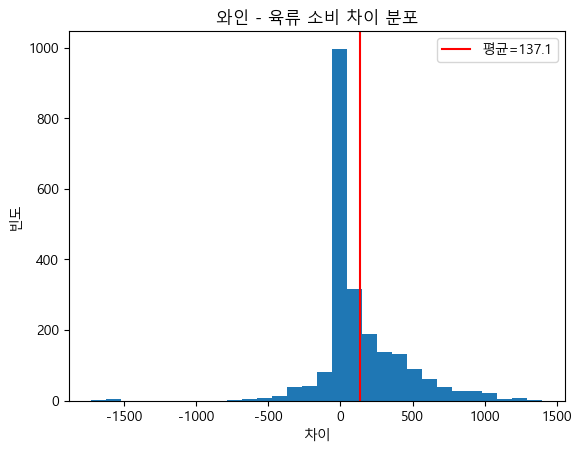

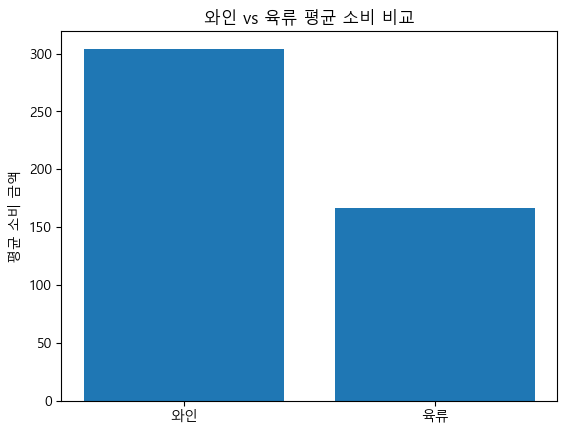

In [51]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
# (1) 대응 차이 히스토그램
plt.figure()
plt.hist(diff, bins=30)
plt.axvline(diff.mean(), color='red', label=f'평균={diff.mean():.1f}')
plt.title('와인 - 육류 소비 차이 분포')
plt.xlabel('차이')
plt.ylabel('빈도')
plt.legend()
plt.show()

# (2) 카테고리별 평균 비교 막대그래프
plt.figure()
plt.bar(['와인', '육류'], [wines.mean(), meat.mean()])
plt.title('와인 vs 육류 평균 소비 비교')
plt.ylabel('평균 소비 금액')
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [53]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
d_32 = 1.2547
n_no = 637
n_yes = 1599
ratio = n_yes / n_no 

power = power_analysis.solve_power(
    effect_size=d_32,
    nobs1=n_no,
    ratio=ratio,
    alpha=0.05
)
print(f"검정력(Power): {power:.4f}")

if power >= 0.8:
    print("검정력 80% 이상으로 충분")
else:
    print("검정력 부족")


# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
n_needed = power_analysis.solve_power(
    effect_size=0.2,
    power=0.8,
    alpha=0.05,
    ratio=1.0
)
n_needed = int(np.ceil(n_needed))
print(f"\n작은 효과(d=0.2) 탐지에 필요한 그룹당 표본 수: {n_needed}명")
print(f"총 필요 표본 수: {n_needed * 2}명")

검정력(Power): 1.0000
검정력 80% 이상으로 충분

작은 효과(d=0.2) 탐지에 필요한 그룹당 표본 수: 394명
총 필요 표본 수: 788명


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [55]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별) 
for g in edu_groups:
    gdata = df[df['Education_Group'] == g]['Total_Spending']
    stat, p = stats.shapiro(gdata)
    print(f"{g}: n={len(gdata)}, W={stat:.4f}, p={p:.4f}")
    if p < 0.05:
        print(f"정규성 기각")
    else:
        print(f"정규성 채택")

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
use_welch = None

groups_data = [df[df['Education_Group'] == g]['Total_Spending'] for g in edu_groups]

stat, p = stats.levene(*groups_data)
print(f"Levene 검정: W={stat:.4f}, p={p:.4f}")

if p < 0.05:
    print("등분산 기각, Welch's ANOVA 사용")
    use_welch = True
else:
    print("등분산 채택, 일반 ANOVA 사용")
    use_welch = False

Undergraduate: n=255, W=0.7605, p=0.0000
정규성 기각
Graduate: n=1126, W=0.8743, p=0.0000
정규성 기각
Postgraduate: n=855, W=0.8765, p=0.0000
정규성 기각
Levene 검정: W=13.2893, p=0.0000
등분산 기각, Welch's ANOVA 사용


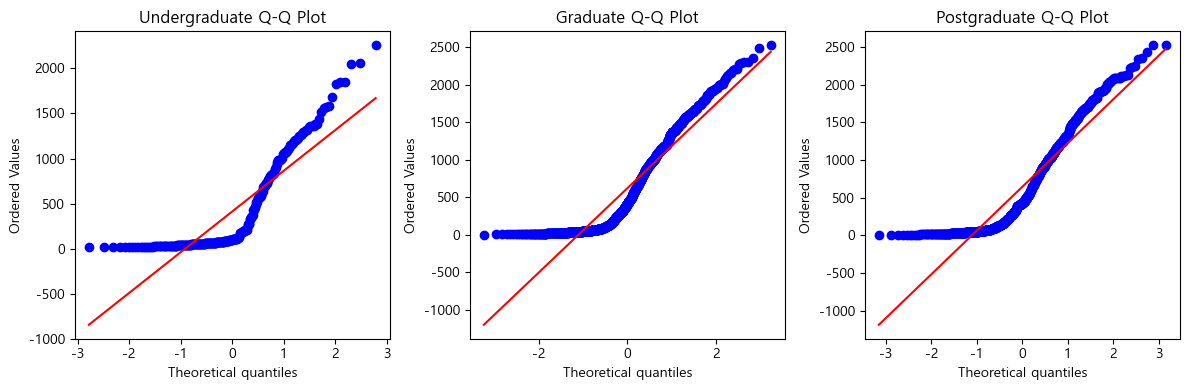

In [56]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
plt.figure(figsize=(12, 4))

for i, g in enumerate(edu_groups):
    gdata = df[df['Education_Group'] == g]['Total_Spending']
    plt.subplot(1, 3, i+1)
    stats.probplot(gdata, plot=plt)
    plt.title(f'{g} Q-Q Plot')

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [60]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
if use_welch:
    result = pg.welch_anova(data=df, dv='Total_Spending', between='Education_Group')
else:
    result = pg.anova(data=df, dv='Total_Spending', between='Education_Group')

print(result)

# Kruskal-Wallis (비모수, 병행)
stat, p = stats.kruskal(*groups_data)
print(f"H통계량: {stat:.4f}, p-value: {p:.4e}")
if p < 0.05:
    print("그룹 간 유의한 차이 있음")
else:
    print("유의한 차이 없음")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
grand_mean = df['Total_Spending'].mean()
k = len(edu_groups)
n_total = len(df)

ss_between = 0
ss_within = 0

for g in edu_groups:
    gdata = group_data[g]
    n_g = len(gdata)
    ss_between += n_g * (gdata.mean() - grand_mean) ** 2
    ss_within += ((gdata - gdata.mean()) ** 2).sum()

ss_total = ss_between + ss_within

ms_within = ss_within / (n_total - k)
eta2 = ss_between / ss_total
omega2 = (ss_between - (k - 1) * ms_within) / (ss_total + ms_within)

print(f"η²  (eta squared) : {eta2:.4f}")
print(f"ω²  (omega squared): {omega2:.4f}")

            Source  ddof1       ddof2          F         p-unc     np2
0  Education_Group      2  751.708152  19.817377  4.098696e-09  0.0137
H통계량: 36.6133, p-value: 1.1208e-08
그룹 간 유의한 차이 있음
η²  (eta squared) : 0.0137
ω²  (omega squared): 0.0128


In [61]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
if use_welch == False:
    tukey = pairwise_tukeyhsd(df['Total_Spending'], df['Education_Group'])
    print(tukey)

    from itertools import combinations
    for g1, g2 in combinations(edu_groups, 2):
        d1 = group_data[g1]
        d2 = group_data[g2]
        pooled = np.sqrt((d1.std(ddof=1)**2 + d2.std(ddof=1)**2) / 2)
        d = (d1.mean() - d2.mean()) / pooled
        print(f"{g1} vs {g2}: Cohen's d = {d:.4f}")

else:
    result = pg.pairwise_gameshowell(data=df, dv='Total_Spending', between='Education_Group')
    print(result[['A', 'B', 'mean(A)', 'mean(B)', 'pval', 'hedges']])

              A              B     mean(A)     mean(B)          pval    hedges
0      Graduate   Postgraduate  620.394316  644.791813  6.523632e-01 -0.040121
1      Graduate  Undergraduate  620.394316  412.254902  8.920656e-08  0.355688
2  Postgraduate  Undergraduate  644.791813  412.254902  9.577128e-09  0.389636


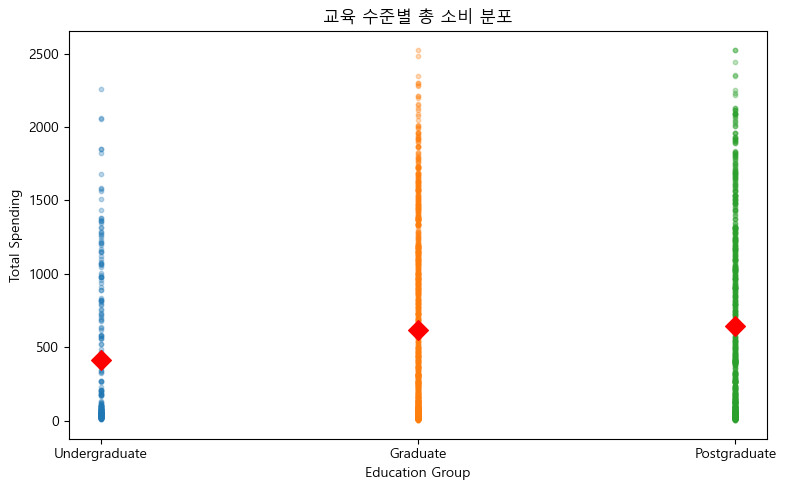

In [62]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
plt.figure(figsize=(8, 5))

for i, g in enumerate(edu_groups):
    gdata = group_data[g]
    plt.scatter([i] * len(gdata), gdata, alpha=0.3, s=10)
    plt.scatter(i, gdata.mean(), marker='D', s=100, color='red', zorder=5)

plt.xticks([0, 1, 2], edu_groups)
plt.title('교육 수준별 총 소비 분포')
plt.xlabel('Education Group')
plt.ylabel('Total Spending')
plt.tight_layout()
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [67]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
chi2, p, dof, expected = stats.chi2_contingency(crosstab_no_margin)

print(f"chi2: {chi2:.4f}, p-value: {p:.4f}, dof: {dof}")

if p < 0.05:
    print("H₀ 기각: 결혼 상태와 캠페인 반응은 독립 아님")
else:
    print("H₀ 채택: 유의한 관계 없음")

total_cells = expected.size
low_cells = (expected < 5).sum()

if low_cells / total_cells <= 0.2:
    print("Cochran 규칙 만족, 카이제곱 검정 적합")
else:
    print("Cochran 규칙 위반, Fisher's exact test 권장")

# TODO 4-3(b): φ (phi) 계산
n_total = crosstab_no_margin.values.sum()
phi = np.sqrt(chi2 / n_total)

print(f"φ (phi): {phi:.4f}")

if phi < 0.1:
    print("효과 크기: 매우 작음")
elif phi < 0.3:
    print("효과 크기: 작음")
elif phi < 0.5:
    print("효과 크기: 중간")
else:
    print("효과 크기: 큼")

# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
table = crosstab_no_margin.values

# 오즈비
a = table[0, 1]  # 그룹1 반응
b = table[0, 0]  # 그룹1 비반응
c = table[1, 1]  # 그룹2 반응
d = table[1, 0]  # 그룹2 비반응

odds_ratio = (a * d) / (b * c)

# 95% CI
log_or = np.log(odds_ratio)
se_log = np.sqrt(1/a + 1/b + 1/c + 1/d)
lower = np.exp(log_or - 1.96 * se_log)
upper = np.exp(log_or + 1.96 * se_log)

print(f"오즈비: {odds_ratio:.4f}")
print(f"95% CI: [{lower:.4f}, {upper:.4f}]")

if lower > 1:
    print("CI가 1을 포함하지 않음, 유의한 차이 있음")
else:
    print("CI가 1을 포함, 유의한 차이 없음")

chi2: 9.2368, p-value: 0.0024, dof: 1
H₀ 기각: 결혼 상태와 캠페인 반응은 독립 아님
Cochran 규칙 만족, 카이제곱 검정 적합
φ (phi): 0.0643
효과 크기: 매우 작음
오즈비: 1.3522
95% CI: [1.1162, 1.6380]
CI가 1을 포함하지 않음, 유의한 차이 있음


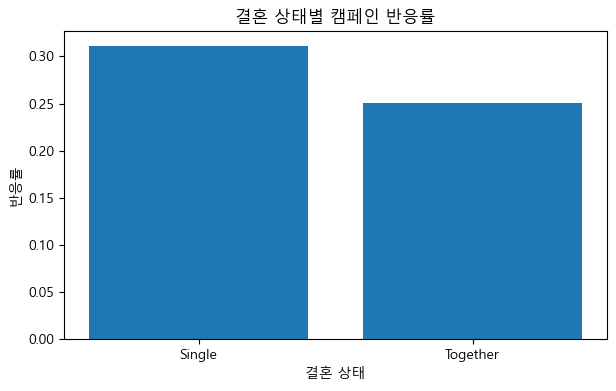

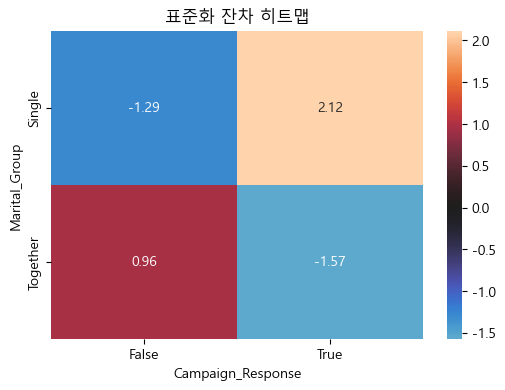

In [71]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵
# 반응률 막대그래프
response_rate = crosstab_no_margin.iloc[:, 1] / crosstab_no_margin.sum(axis=1)

plt.figure(figsize=(7, 4))
plt.bar(response_rate.index, response_rate.values)
plt.title('결혼 상태별 캠페인 반응률')
plt.xlabel('결혼 상태')
plt.ylabel('반응률')
plt.show()

# 표준화 잔차 히트맵
std_resid = (crosstab_no_margin.values - expected) / np.sqrt(expected)
std_resid_df = pd.DataFrame(std_resid,
                             index=crosstab_no_margin.index,
                             columns=crosstab_no_margin.columns)

plt.figure(figsize=(6, 4))
sns.heatmap(std_resid_df, annot=True, fmt='.2f', center=0)
plt.title('표준화 잔차 히트맵')
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [73]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정

n_total = observed.sum()
expected_equal = [n_total / 3, n_total / 3, n_total / 3]

chi2, p = stats.chisquare(observed, f_exp=expected_equal)

print(f"chi2: {chi2:.4f}, p-value: {p:.4e}")

if p < 0.05:
    print("H₀ 기각: 채널별 구매 수가 균등하지 않음")
else:
    print("H₀ 채택: 채널별 구매 수가 균등함")

# TODO 4-4(b): Cohen's w 계산
cohen_w = np.sqrt(chi2 / n_total)
print(f"Cohen's w: {cohen_w:.4f}")

chi2: 2630.1063, p-value: 0.0000e+00
H₀ 기각: 채널별 구매 수가 균등하지 않음
Cohen's w: 0.3062


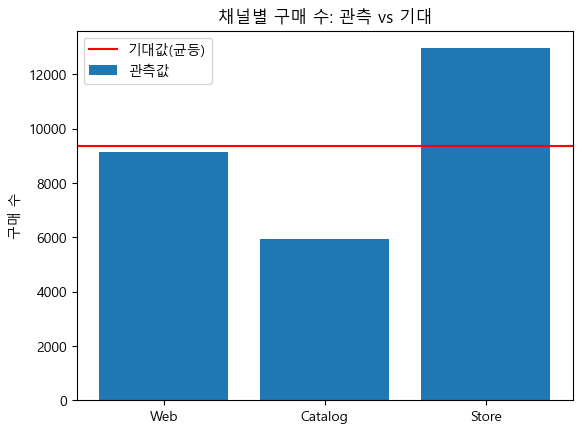

In [75]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

plt.figure()
plt.bar(channel_names, observed, label='관측값')
plt.axhline(n_total / 3, color='red', linestyle='-', label='기대값(균등)')
plt.title('채널별 구매 수: 관측 vs 기대')
plt.ylabel('구매 수')
plt.legend()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [83]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산

pearson_corr = df[corr_vars].corr(method='pearson')
spearman_corr = df[corr_vars].corr(method='spearman')

print(pearson_corr.round(2))
print(spearman_corr.round(2))

# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
r, p = stats.pearsonr(df['Income'], df['Total_Spending'])
print("Income vs Total_Spending")
print("r:", round(r, 4), "p:", round(p, 4))

r, p = stats.pearsonr(df['NumWebVisitsMonth'], df['Total_Spending'])
print("NumWebVisitsMonth vs Total_Spending")
print("r:", round(r, 4), "p:", round(p, 4))

r, p = stats.pearsonr(df['Total_Spending'], df['Total_Purchases'])
print("Total_Spending vs Total_Purchases")
print("r:", round(r, 4), "p:", round(p, 4))


                   Income   Age  Total_Spending  Total_Purchases  \
Income               1.00  0.20            0.79             0.74   
Age                  0.20  1.00            0.11             0.17   
Total_Spending       0.79  0.11            1.00             0.82   
Total_Purchases      0.74  0.17            0.82             1.00   
NumWebVisitsMonth   -0.65 -0.12           -0.50            -0.43   
Recency              0.01  0.02            0.02             0.01   

                   NumWebVisitsMonth  Recency  
Income                         -0.65     0.01  
Age                            -0.12     0.02  
Total_Spending                 -0.50     0.02  
Total_Purchases                -0.43     0.01  
NumWebVisitsMonth               1.00    -0.02  
Recency                        -0.02     1.00  
                   Income   Age  Total_Spending  Total_Purchases  \
Income               1.00  0.22            0.85             0.78   
Age                  0.22  1.00            0.16    

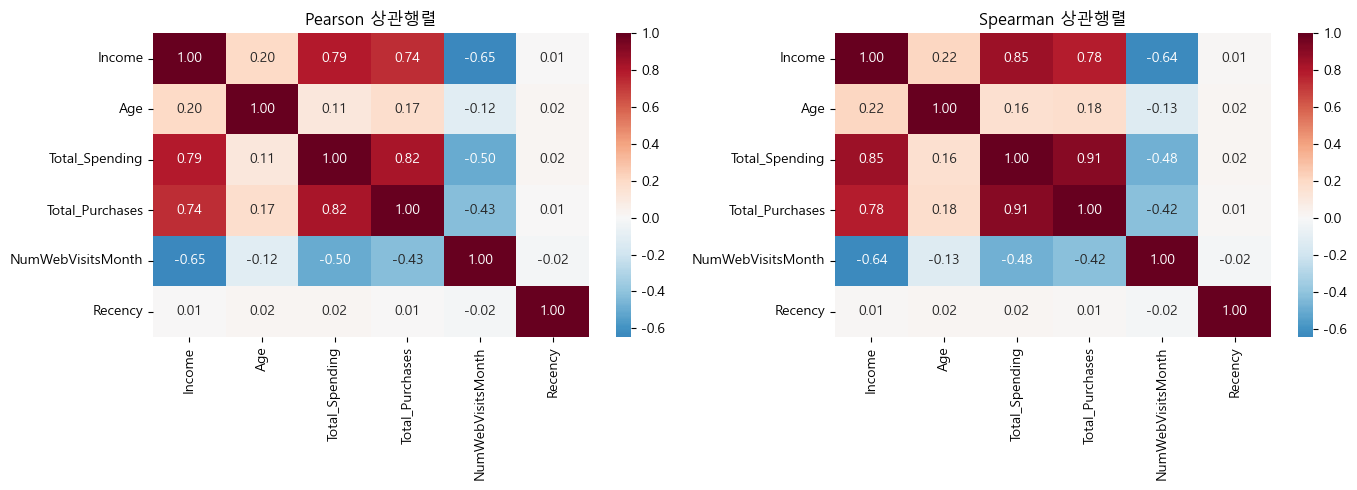

In [88]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Pearson 상관행렬')

plt.subplot(1, 2, 2)
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Spearman 상관행렬')

plt.tight_layout()
plt.show()

In [90]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요


### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [94]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
count = np.array([conv_a, conv_b])
nobs = np.array([n_a, n_b])

z, p = proportions_ztest(count, nobs)

print("그룹 A (이전 캠페인 미반응)")
print("n:", n_a, "반응:", conv_a, "반응률:", round(rate_a, 4))

print("그룹 B (이전 캠페인 반응)")
print("n:", n_b, "반응:", conv_b, "반응률:", round(rate_b, 4))

print("\nz통계량:", round(z, 4))
print("p-value:", round(p, 4))

if p < 0.05:
    print("H₀ 기각: 두 그룹 간 반응률 차이 있음")
else:
    print("H₀ 채택: 유의한 차이 없음")

# TODO 5-2(b): Cohen's h 효과 크기
h = proportion_effectsize(rate_a, rate_b)

print("Cohen's h:", round(abs(h), 4))

# TODO 5-2(c): Wilson 신뢰구간
lower_a, upper_a = proportion_confint(conv_a, n_a, method='wilson')
lower_b, upper_b = proportion_confint(conv_b, n_b, method='wilson')

print("그룹 A 95% CI:", round(lower_a, 4), "~", round(upper_a, 4))
print("그룹 B 95% CI:", round(lower_b, 4), "~", round(upper_b, 4))

그룹 A (이전 캠페인 미반응)
n: 1774 반응: 146 반응률: 0.0823
그룹 B (이전 캠페인 반응)
n: 462 반응: 188 반응률: 0.4069

z통계량: -17.4357
p-value: 0.0
H₀ 기각: 두 그룹 간 반응률 차이 있음
Cohen's h: 0.8016
그룹 A 95% CI: 0.0704 ~ 0.096
그룹 B 95% CI: 0.3631 ~ 0.4523


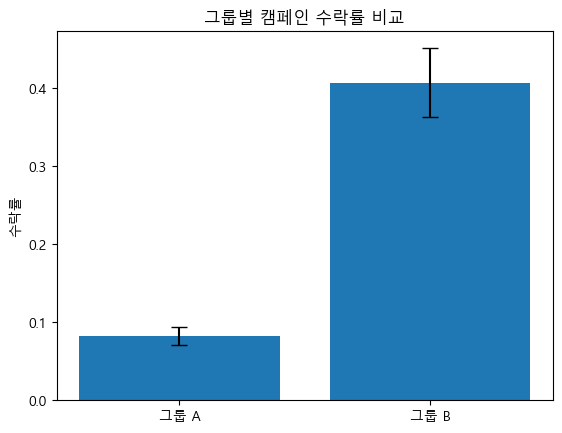

In [95]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
means = [rate_a, rate_b]
errors = [rate_a - lower_a, rate_b - lower_b]

plt.figure()
plt.bar(['그룹 A', '그룹 B'], means, yerr=errors, capsize=6)
plt.title('그룹별 캠페인 수락률 비교')
plt.ylabel('수락률')
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [97]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
h = proportion_effectsize(baseline_rate, target_rate)

print("기준 반응률:", round(baseline_rate, 4))
print("목표 반응률:", round(target_rate, 4))
print("Cohen's h:", round(abs(h), 4))

# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_model = NormalIndPower()

n = power_model.solve_power(
    effect_size=abs(h),
    alpha=0.05,
    power=0.80,
    alternative='larger'
)

n = int(np.ceil(n))
print("그룹당 필요 표본 수:", n)
print("총 필요 표본 수:", n * 2)

기준 반응률: 0.1494
목표 반응률: 0.1694
Cohen's h: 0.0547
그룹당 필요 표본 수: 4138
총 필요 표본 수: 8276


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛